# Bulk ingestion demo (inserts)

This demo shows our prototype for faster bulk ingestion into LanceDB. We'll look at two demo ingestion pipelines:

1. A straightforward upload of the TPCH `lineitem` tables (SF=5) from Parquet.
2. An upload of a 10 million row sample of the english wikipedia huggingface dataset, with vector embeddings generated on ingestion using a local mock of openAI.

## Background

### Existing APIs

This work isn't about creating any new user-facing APIs, but instead making existing insert pipeline faster and more reliable for large inserts.

Most users insert data through the LanceDB SDKs: in Python, Typescript, or Rust. Python users can pass in a variety of inputs, from dataframes, to on-disk datasets, to streaming query results.

```python
data = pd.DataFrame({'id': [1, 2, 3]})
table.add(data)

import pyarrow.dataset as pa_ds
dataset = pa_ds.dataset("path/to/files", format="parquet")
table.add(dataset)

import duckdb
data = duckdb.sql("SELECT * FROM big_table").execute().to_arrow()
table.add(data)
```

LanceDB Enterprise recieves writes through an HTTP API, which takes an Arrow IPC stream as the input body. Part of the appeal of the SDKs is they handle the details of converting to Arrow data and serializing the IPC stream.

The LanceDB CLI had a LOAD command, which is a wrapper around the Rust SDK.

```shell
lancedb load -s hf --dataset "KShivendu/dbpedia-entities-openai-1M" -t dbpedia --vector-column openai --text-column text
```


## Ingestion pipeline

The client does a substantial amount of preprocessing before sending the data to LanceDB. The steps are:

* `Convert to Arrow`: If data isn't already in Arrow format (e.g. a Pandas DataFrame, list of dicts, etc), convert it to Arrow.
* `Generate Embeddings`: If the user has specified a vector column that needs to be generated from a registered embedding model (e.g. OpenAI), call the model API to generate embeddings for the relevant column(s).
* `Handle invalid vectors`: If any vectors are missing or invalid (wrong dimension, NaNs, etc), handle them according to user-specified policy (e.g. drop rows, fill with zeros, raise error).
* `Cast to table schema`: Ensure the Arrow data matches the LanceDB table schema, casting columns as necessary.
* `Write to LanceDB`: Serialize the Arrow data to an IPC stream and send it to the LanceDB server via the HTTP API.

```mermaid
graph LR
    A[Input Data] --> B[Convert to Arrow];
    B --> C[Generate Embeddings];
    C --> D[Handle invalid vectors];
    D --> E[Cast to table schema];
    E --> F[Write to LanceDB];
```

### Performance optimizations

1. LZ4 compression of Arrow IPC stream
2. Streaming upload to LanceDB server
3. Parallel pre-preprocessing (at number of CPU cores)
4. Parallel HTTP requests to LanceDB server (decided based on data size and number of rows). This required adding new endpoints to separate the writing of data from the final commit.

## Part 1: Upload 10GB of TPCH lineitem data from Parquet

In [33]:
!rm -r lineitem
!tpchgen-cli -s 10 --tables lineitem --parts 5 --format=parquet

/home/will/Documents/lancedb/python/python/lancedb/__init__.py:289: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(


In [1]:
import pyarrow.dataset as pa_ds
import os

parquet_ds = pa_ds.dataset("lineitem")

size_bytes = sum(os.path.getsize(f) for f in parquet_ds.files)
print(f"{parquet_ds.count_rows():,} rows, {size_bytes / (1024**3):.2f} GB")
parquet_ds.head(2).to_pandas()

59,986,052 rows, 2.37 GB


,l_orderkey,l_partkey,l_suppkey,l_linenumber,l_quantity,l_extendedprice,l_discount,l_tax,l_returnflag,l_linestatus,l_shipdate,l_commitdate,l_receiptdate,l_shipinstruct,l_shipmode,l_comment
0,1,1551894,76910,1,17.00,33078.94,0.04,0.02,N,O,1996-03-13,1996-02-12,1996-03-22,DELIVER IN PERSON,TRUCK,egular courts above the
1,1,673091,73092,2,36.00,38306.16,0.09,0.06,N,O,1996-04-12,1996-02-28,1996-04-20,TAKE BACK RETURN,MAIL,ly final dependencies: slyly bold


In [11]:
import lancedb
import tqdm
import shutil

db = lancedb.connect("demo")
# shutil.rmtree("demo", ignore_errors=True)
# db = lancedb.connect(
#     uri="db://dev",
#     host_override="http://localhost:10024",
#     api_key="sk_localtest",
#     client_config={
#         "retry_config": {"retries": 2},
#         "timeout_config": {
#             "timeout": 500,
#         },
#     },
# )
table = db.create_table("lineitem", schema=parquet_ds.schema, mode="overwrite")

[2026-02-05T19:44:00Z WARN  lance::dataset::write::insert] No existing dataset at /home/will/Documents/lancedb/python/demo/lineitem.lance, it will be created


In [ ]:
# Single-threaded, LZ4 compression
with tqdm.tqdm() as pbar:
    table.add(parquet_ds, progress=pbar)

0it [00:00, ?it/s]

59986052it [00:23, 2528133.76it/s, bytes=9.4GB, throughput=408.2MB/s]  


In [4]:
# Single-threaded, no compression (it's slower on against a local dev server)
with tqdm.tqdm() as pbar:
    table.add(parquet_ds, progress=pbar, compression=None, write_parallelism=1)

7428600it [00:03, 2475712.25it/s, bytes=1.2GB, throughput=416.2MB/s]   


KeyboardInterrupt: 

In [4]:
with tqdm.tqdm() as pbar:
    table.add(parquet_ds, progress=pbar, compression=None, write_parallelism=2)

58615284it [00:10, 5932438.38it/s, bytes=9.3GB, throughput=877.0MB/s]  Uploaded 256 batches: serializing_time=0.95s, pulling_time=0.24s
59986052it [00:11, 4272856.32it/s, bytes=9.5GB, throughput=859.7MB/s]Uploaded 269 batches: serializing_time=1.00s, pulling_time=0.09s
59986052it [00:11, 5046122.18it/s, bytes=9.5GB, throughput=859.7MB/s]


In [34]:
with tqdm.tqdm() as pbar:
    table.add(parquet_ds, progress=pbar, compression=None, write_parallelism=4)

59986052it [01:13, 812281.02it/s, bytes=9.5GB, throughput=133.7MB/s]   


In [12]:
import time

parallelism_levels = [1, 2, 4, 16]
times = []
for parallelism in parallelism_levels:
    start_time = time.time()
    with tqdm.tqdm() as pbar:
        table.add(parquet_ds, progress=pbar, compression=None, write_parallelism=parallelism)
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)
    print(f"Parallelism: {parallelism}, Time: {elapsed_time:.2f} seconds")

59986052it [00:23, 2567671.51it/s, bytes=9.4GB, throughput=414.5MB/s]  


Parallelism: 1, Time: 23.37 seconds


59986052it [00:27, 2180724.49it/s, bytes=9.4GB, throughput=353.1MB/s]  


Parallelism: 2, Time: 27.51 seconds


59986052it [00:46, 1297905.73it/s, bytes=9.4GB, throughput=211.3MB/s]  


Parallelism: 4, Time: 46.22 seconds


59986052it [00:58, 1024301.99it/s, bytes=9.4GB, throughput=167.1MB/s]  

Parallelism: 16, Time: 58.57 seconds


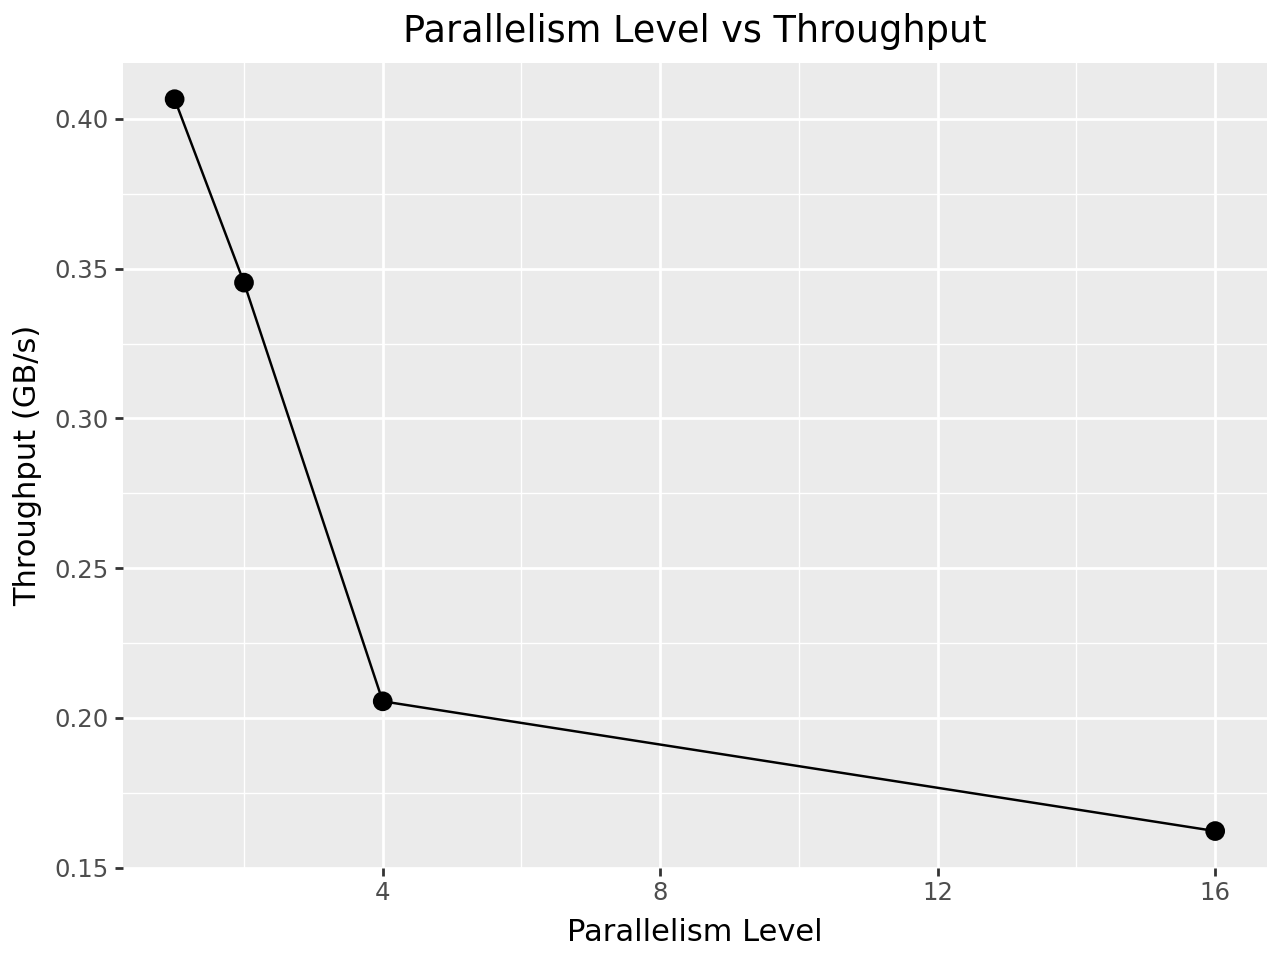

In [13]:
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal
import pandas as pd

# Make a chart of parallelism level vs throughput
parallelism_levels = [1, 2, 4, 16]
size_bytes = 9.5 * 1024**3  # 9.5 GB
throughput = [size_bytes / t / (1024**3) for t in times]  # GB/s
# use plotnine
# Create sample data for parallelism vs throughput
# (these would be actual measurements from cells 8-12)
data = pd.DataFrame({
    'parallelism': parallelism_levels,
    'throughput_gbps': throughput  # example values
})

(ggplot(data, aes(x='parallelism', y='throughput_gbps'))
 + geom_point(size=3)
 + geom_line()
 + labs(title='Parallelism Level vs Throughput',
        x='Parallelism Level',
        y='Throughput (GB/s)'))

## Part 2: Upload 10 million rows of wikipedia data with on-the-fly embeddings

In [23]:
from datasets import load_dataset

hf_ds = (
    load_dataset("wikimedia/wikipedia", "20231101.en", split="train", streaming=True)
    .take(10_000)
)
list(hf_ds.take(2))

[{'id': '12',
  'url': 'https://en.wikipedia.org/wiki/Anarchism',
  'title': 'Anarchism',
  'text': 'Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism. Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations. As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as the libertarian wing of the socialist movement (libertarian socialism).\n\nHumans have lived in societies without formal hierarchies long before the establishment of states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose. Although traces of anarchist ideas are found all throughout history, modern anarchism emerged from the Enlightenment.

In [24]:
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector

title_func = get_registry().get("openai").create(name="text-embedding-3-small", dim=512)
embedding_func = get_registry().get("openai").create(name="text-embedding-3-large")

class WikiPage(LanceModel):
    id: int
    url: str
    title: str = title_func.SourceField()
    title_embedding: Vector(512) = title_func.VectorField()
    text: str = embedding_func.SourceField()
    embedding: Vector(3072) = embedding_func.VectorField()

wiki_table = db.create_table("wikipedia", schema=WikiPage, mode="overwrite")

In [25]:
%env OPENAI_API_KEY=your_api_key_here
%env OPENAI_BASE_URL=http://localhost:8000

env: OPENAI_API_KEY=your_api_key_here
env: OPENAI_BASE_URL=http://localhost:8000


In [26]:
with tqdm.tqdm() as pbar:
    wiki_table.add(hf_ds, progress=pbar)

10000it [00:47, 209.05it/s, bytes=225.6MB, throughput=5.0MB/s]
